In [96]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
import pickle #to download MLP vectors
from scipy.stats import entropy, variation
import random
from scipy.stats import kurtosis

#plot
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import nbrh_WG_open, mid_cum_Z4_sec
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
C:\Users\camil\anaconda3\lib\site-packages\gensim\matutils.py:24: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu
C:\Users\camil\anaconda3\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


2


In [3]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
dico_garden_opening_hour = config.dico_garden_opening_hour
id_run = config.id_run
mindur_toaccountforZ4 = config.mindur_toaccountforZ4
dico_matching = config.dico_matching
print(id_run)

change the configuration file if not done yet!
ALLDATA_


# Download data

In [4]:
#KBF&severity
df_HA = pd.read_csv(os.path.join(path_extracted_data, 'df_all_HA.csv'), sep=';', parse_dates=['date'], dayfirst=True) 
df_HA['FeatherDamage'] = df_HA['Feathers'].map(lambda x: 100-x)
df_HA['date_HA'] = df_HA['date'].copy()
df_HA = df_HA[~df_HA['HenID'].isnull()] #two isntances
print(df_HA.shape)
#display(df_HA.groupby(['HAID'])['date'].agg(lambda x: set(x)).reset_index())
display(df_HA['HAID'].value_counts())
#info on date
display(df_HA.groupby(['HAID','date','WOA','DOA'])['HenID'].count().reset_index())
print(df_HA.shape)
df_HA.head(3)

(844, 60)


HA3    176
HA4    176
HA1    175
HA2    160
HA5    157
Name: HAID, dtype: int64

,HAID,date,WOA,DOA,HenID
0,HA1,2020-11-23,25.0,173.0,175
1,HA2,2021-01-04,31.0,215.0,160
2,HA3,2021-02-01,35.0,243.0,176
3,HA4,2021-04-12,45.0,313.0,176
4,HA5,2021-07-25,60.0,417.0,157


(844, 60)


,Person_toe,Time,PenID,FocalLegringName,BirdType,CombPecks,Toes,RFPododermatitis,RFBumblefoot,RFinjuries,...,random_order1,severity,has_gap,BirdID,uncertainty (0:certain:1 random),Unnamed: 9,Info,backpack,FeatherDamage,date_HA
0,M,09:30,pen9,42grey,normal,25.0,NaN,0.0,0.0,0.0,...,109.0,0,0.0,42grey9sb,NaN,NaN,"['', '42', 'grey', '9', 'sb']",sb,NaN,2020-11-23
1,Mark,14:54,pen9,66grey,normal,0.0,NaN,50.0,0.0,0.0,...,509.0,16,0.0,66grey9sp,NaN,NaN,"['', '66', 'grey', '9', 'sp']",sp,14.0,2021-02-01
2,Camille,10:30,pen5,2green,normal,130.0,NaN,25.0,0.0,0.0,...,428.0,4,0.0,2green5pp,NaN,NaN,"['', '2', 'green', '5', 'pp']",pp,8.0,2021-02-01


In [5]:
#focal birds information (one row per focal bird)
df_FB = pd.read_csv(os.path.join(path_extracted_data, id_run+'df_FOCALBIRDS.csv'), sep=';',
                    parse_dates=['InitialStartDate'], dayfirst=True)
print(df_FB.shape)
df_FB.head(3)

(232, 14)


,HenID,PenID,CLASS,R-Pen,InitialStartDate,early_death,29-09 weight,10-12 juin weight,weight 23-11-2020,weight 04-01-2021,weight 01-02-21,weight 12-04-21,weight 26-07-21,Treatment
0,hen_1,9,EPI,1.0,2020-06-10,0.0,1134.0,57.0,1696.5,1787.8,1800.9,NaN,NaN,OFH
1,hen_10,11,LEXP,1.0,2020-06-10,0.0,1070.0,70.4,1488.3,1628.4,1602.1,1587.2,1713.4,OFH
2,hen_100,5,EPI,3.0,2020-06-10,0.0,1182.0,80.5,1642.5,NaN,NaN,NaN,NaN,OFH


In [7]:
#daily var
df_daily_init = pd.read_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_variables.csv'), sep=';',
                 parse_dates=['level', 'FirstTimestamp_1_Zone', 'FirstTimestamp_2_Zone', 'FirstTimestamp_3_Zone',
                             'FirstTimestamp_4_Zone','FirstTimestamp_5_Zone'],
                 dayfirst=True) 
df_daily_init = df_daily_init[df_daily_init['level']!=dt.datetime(2021,7,25)]
print(df_daily_init.shape)
df_daily_init.head(3)

(39382, 70)


,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,...,night_Max_duration_zones,night_duration_Z5,night_Total_number_transition,is_mvt_night,nbr_h_per_day,correct_amount_of_hour,DOA,WOA,DIB,WIB
0,hen_130,2020-10-05,NaN,0.0,0.0,0.0,32400.0,32400.0,9.0,"[0.0, 0.0, 0.0, 0.0, 32400.0]",...,5_Zone,54000.0,0.0,0.0,9,True,124,18,6,1
1,hen_130,2020-10-06,NaN,0.0,780.0,325.0,31295.0,32400.0,9.0,"[0.0, 0.0, 780.0, 325.0, 31295.0]",...,3_Zone,5363.0,1.0,1.0,9,True,125,18,7,1
2,hen_130,2020-10-07,NaN,206.0,249.0,130.0,31815.0,32400.0,9.0,"[0.0, 206.0, 249.0, 130.0, 31815.0]",...,5_Zone,54000.0,0.0,0.0,9,True,126,18,8,2


In [91]:
#daily variables of the movements (one row per available hen per day)
df_daily = pd.read_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_variables_verified.csv'), sep=';',
                     parse_dates=['level'], dayfirst=True)
print(df_daily.shape)
#removing days with closed WG (removing two vaccinations date)
df_daily = df_daily[~df_daily['level'].isin(list(config.close_dates))]
print(df_daily.shape)
df_daily = df_daily[~df_daily['night_level'].isnull()]
print(df_daily.shape)    
df_daily.head(3)

(39382, 82)
(38625, 82)
(38175, 82)


,HenID,level,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone,perc_duration_2_Zone,perc_duration_1_Zone,...,weight_interp,food_sameDurTiming_r50_final,food_sameDurTiming_r50_AP_final,food_sameDurTiming_r50_AB_final,duration_1_Zone_min,duration_2_Zone_min,duration_3_Zone_min,duration_4_Zone_min,duration_5_Zone_min,Has_been_toptier_wholeday
0,hen_130,2020-10-05,32400.0,9.0,"[0.0, 0.0, 0.0, 0.0, 32400.0]",0.0,0.0,100.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.00,0.000000,540.000000,True
1,hen_130,2020-10-06,32400.0,9.0,"[0.0, 0.0, 780.0, 325.0, 31295.0]",2.0,1.0,97.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,13.00,5.416667,521.583333,False
2,hen_130,2020-10-07,32400.0,9.0,"[0.0, 206.0, 249.0, 130.0, 31815.0]",1.0,0.0,98.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,3.433333,4.15,2.166667,530.250000,False


# HA interpolation

In [9]:
#np.interp:  linear interpolation for monotonically increasing sample points
def inter_HA(HenID, DOA, df_HA, df_FB, str_ha):
    
    if str_ha not in df_HA.columns:
        print('error, specify an exist column name')
        sys.exit()
        
    #available HA days, for that specific hen
    li_DOA = np.array(df_HA[(df_HA['HenID']==HenID)&(~df_HA[str_ha].isnull())]['DOA'].unique())
    if len(li_DOA)==0:
        return np.nan
    mi = min(li_DOA)
    ma = max(li_DOA)
        
    #if its an exact date (never happen, except for last date, which we put to be the date previous the real HA)
    if DOA in li_DOA:
        return df_HA[(df_HA['HenID']==HenID)&(df_HA['DOA']==DOA)][str_ha].iloc[0]
    
    #if its lower date than the first measured HA, then add the timestamp 0 when they moved to the laying barn, but only if the
    #first health assessment (DOA 173) is available for that bird
    if (DOA<mi) & (str_ha=='weight'):
        x2 = li_DOA[li_DOA > DOA].min()
        if x2==173:
            wdoa119 = df_FB[df_FB['HenID']==HenID]['29-09 weight'].iloc[0]
            return(np.interp(DOA, xp=(119,x2), fp=(wdoa119, df_HA[(df_HA['HenID']==HenID)&(df_HA['DOA']==x2)][str_ha].iloc[0])))        
        
    #if its lower date than the first measured HA, then assume 0 for all when transfer to LB
    if (DOA<mi) & (str_ha=='severity'):
        x2 = li_DOA[li_DOA > DOA].min()
        if x2==173:
            return(np.interp(DOA, xp=(119,x2), fp=(0, df_HA[(df_HA['HenID']==HenID)&(df_HA['DOA']==x2)][str_ha].iloc[0])))   

    #if its lower date than the first measured HA (for feather it 215 DOA, then assume 0 for all when transfer to LB
    if (DOA<mi) & (str_ha=='FeatherDamage'):
        x2 = li_DOA[li_DOA > DOA].min()
        if x2==215:
            return(np.interp(DOA, xp=(119,x2), fp=(0, df_HA[(df_HA['HenID']==HenID)&(df_HA['DOA']==x2)][str_ha].iloc[0])))   
        
    if DOA<mi:
        return np.nan
        
    #if its at the higher boundery, then add the KBF from that time (can happen with for example early death)
    if DOA>ma:
        return(df_HA[(df_HA['HenID']==HenID)&(df_HA['DOA']==ma)][str_ha].iloc[0])        

    #else if its in between min and max available date with health data return interpolation between thoe two measured HA
    x1 = li_DOA[li_DOA < DOA].max() #largest available HA date below the date we want to find the interpolated HA
    x2 = li_DOA[li_DOA > DOA].min() #smallest available HA date above the date we want to find the interpolated HA
    return(np.interp(DOA, xp=(x1,x2), 
                     fp=(df_HA[(df_HA['HenID']==HenID)&(df_HA['DOA']==x1)][str_ha].iloc[0],
                         df_HA[(df_HA['HenID']==HenID)&(df_HA['DOA']==x2)][str_ha].iloc[0])))


print('---------- KBF interpolation computation................')        
df_daily['KBF_interp'] = df_daily.apply(lambda x: inter_HA(HenID=x['HenID'], DOA=x['DOA'], 
                                                           df_HA=df_HA, df_FB=df_FB, str_ha='severity'), axis=1)
print('---------- FeatherDamage computation................')
df_daily['FeatherDamage_interp'] = df_daily.apply(lambda x: inter_HA(HenID=x['HenID'], DOA=x['DOA'], 
                                                              df_HA=df_HA, df_FB=df_FB, str_ha='FeatherDamage'), axis=1)
print('---------- weight computation................')
df_daily['weight_interp'] = df_daily.apply(lambda x: inter_HA(HenID=x['HenID'], DOA=x['DOA'], 
                                                              df_HA=df_HA, df_FB=df_FB, str_ha='weight'), axis=1)

---------- KBF interpolation computation................
---------- FeatherDamage computation................
---------- weight computation................


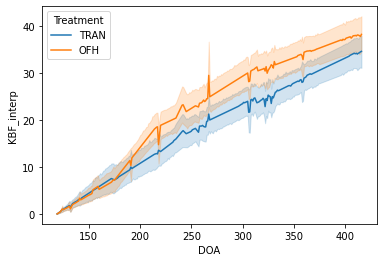

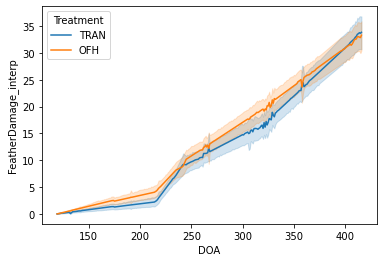

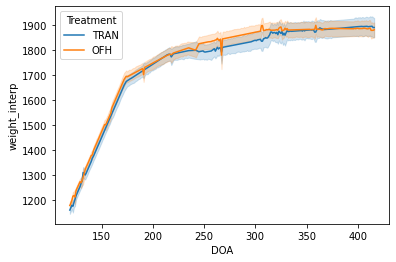

In [10]:
sns.lineplot(x='DOA', y='KBF_interp', hue='Treatment', data=df_daily);
plt.show()
sns.lineplot(x='DOA', y='FeatherDamage_interp',  hue='Treatment', data=df_daily);
plt.show()
sns.lineplot(x='DOA', y='weight_interp', hue='Treatment', data=df_daily);

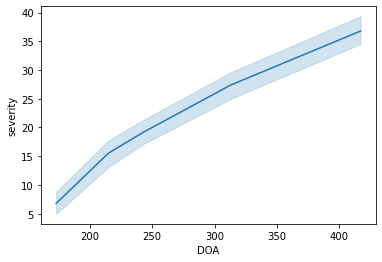

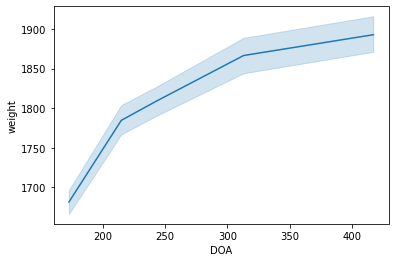

In [11]:
sns.lineplot(x='DOA', y='severity', data=df_HA);
plt.show()
#sns.lineplot(x='DOA', y='FeatherDamage',  data=df_HA);
#plt.show()
sns.lineplot(x='DOA', y='weight', data=df_HA);

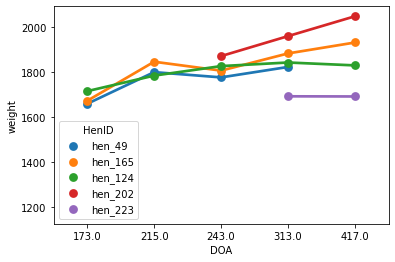

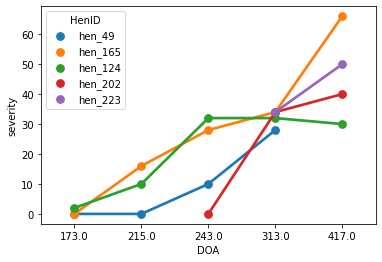

In [32]:
import random
random.seed(1)
#li_h = random.sample(list(df_daily['HenID'].unique()), 5)
li_h = ['hen_49','hen_165','hen_124','hen_202','hen_223'] #chosen initially randomly but cant remmeber the r.seed
sns.lineplot(x='DOA', y='weight_interp', hue='HenID', data=df_daily[df_daily['HenID'].isin(li_h)], legend=False);
sns.pointplot(x='DOA', y='weight', hue='HenID', data=df_HA[df_HA['HenID'].isin(li_h)]);
plt.show()

sns.lineplot(x='DOA', y='KBF_interp', hue='HenID', data=df_daily[df_daily['HenID'].isin(li_h)], legend=False);
sns.pointplot(x='DOA', y='severity', hue='HenID', data=df_HA[df_HA['HenID'].isin(li_h)]);

# nestboxtier timing - interval time

In [13]:
df_daily[['HenID','level','mid_cum_Z4_h_Morning']].head(2)

,HenID,level,mid_cum_Z4_h_Morning
0,hen_130,2020-10-05,NaN
1,hen_130,2020-10-06,NaN


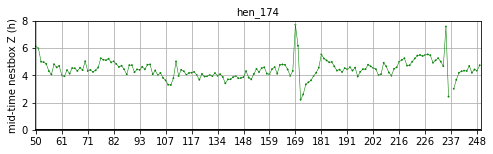

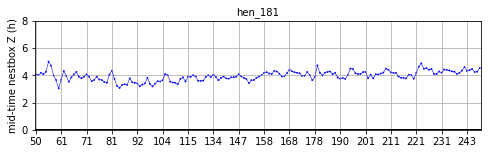

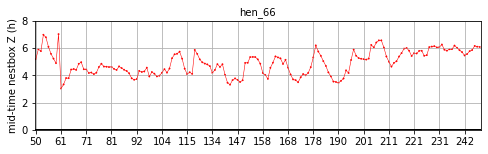

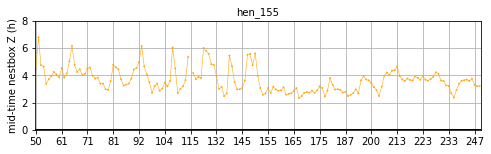

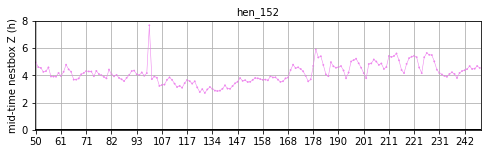

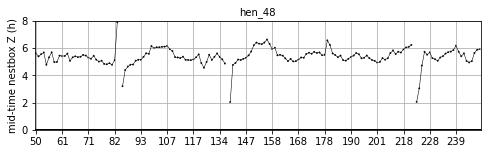

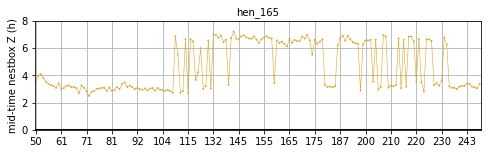

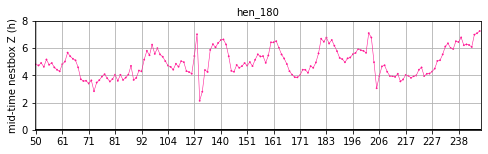

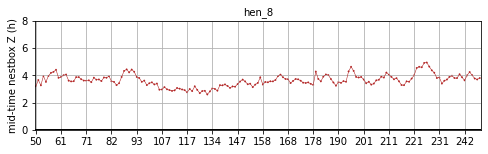

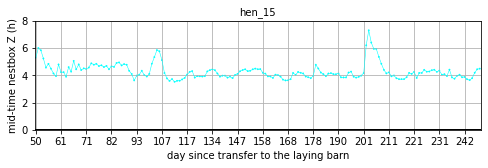

In [14]:
from matplotlib.ticker import MultipleLocator
li_s = ['hen_174','hen_181','hen_66','hen_155','hen_152','hen_48','hen_165','hen_180','hen_8','hen_15']
for i, (h,c) in enumerate(zip(li_s,['green','blue','red','orange','violet','black','goldenrod','deeppink','firebrick','cyan'])):
    plt.figure(figsize=(8, 2))
    ax = sns.pointplot(x='DIB', y='mid_cum_Z4_h_Morning', 
                 data=df_daily[(df_daily['HenID']==h)&(df_daily['DIB'].isin(range(50,250)))], color=c, scale=0.2);
    plt.axhline(y=0, linewidth=2, color = 'k')
    plt.ylim((0,8))
    plt.title(h, size=10)
    plt.ylabel('mid-time nestbox Z (h)')
    if i==len(li_s)-1:
        plt.xlabel('day since transfer to the laying barn')
    else:
        ax.set(xlabel=None) 
    ax.xaxis.set_major_locator(MultipleLocator(10))
    plt.grid(True)
    plt.savefig(os.path.join(path_extracted_data,h+'_half_time_innestboxZ.png'),dpi=300,format='png',bbox_inches='tight')
    plt.show()
#IF WE WANT TO KEEP THIS we need to add missing days in grey

,level,mid_cum_Z4_h_Morning,previous_mid_cum_Z4_h_Morning,Intervaltime_midcumZ4hmorning_h
34456,2021-01-20,3.652222,3.385833,24.266389
34457,2021-01-21,3.787222,3.652222,24.135000
34458,2021-01-22,3.889167,3.787222,24.101944
34459,2021-01-23,3.628611,3.889167,23.739444
34460,2021-01-24,3.821667,3.628611,24.193056


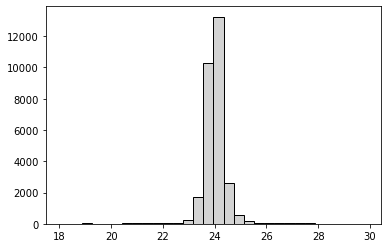

In [15]:
#add interval time between two days of the mid nestbox zone usage
#not efficient, but small data so I'd rather keep it short in lines than short in time here (takes 1mn to run)
df_daily['previous_mid_cum_Z4_h_Morning'] = df_daily.apply(lambda x: df_daily[(df_daily['HenID']==x['HenID'])&\
                                                                              (df_daily['level']==x['level']-dt.timedelta(days=1))]['mid_cum_Z4_h_Morning'].values, axis=1)
df_daily['previous_mid_cum_Z4_h_Morning'] = df_daily['previous_mid_cum_Z4_h_Morning'].map(lambda x: x[0] if len(x)==1 else np.nan)
df_daily['Intervaltime_midcumZ4hmorning_h'] = df_daily.apply(lambda x: 24+(x['mid_cum_Z4_h_Morning']-x['previous_mid_cum_Z4_h_Morning']) if not math.isnan(x['previous_mid_cum_Z4_h_Morning']) else np.nan, axis=1)
#Note: mid_durationafterlightturnedon_Z4_h_Morning: should be used rather than mid_cum_Z4_h_Morning, if the light was not 
#turned on at a same time always, when turned on before 8h
#small check
display(df_daily[df_daily['HenID']=='hen_1'][['level','mid_cum_Z4_h_Morning','previous_mid_cum_Z4_h_Morning','Intervaltime_midcumZ4hmorning_h']].tail(5))
plt.hist(df_daily['Intervaltime_midcumZ4hmorning_h'], color='lightgrey', edgecolor = "black", bins=30);

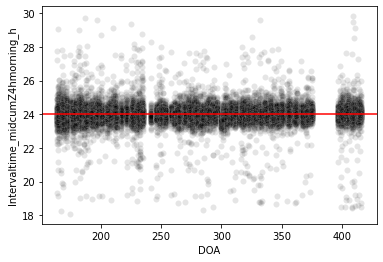

In [16]:
sns.scatterplot(y='Intervaltime_midcumZ4hmorning_h',x='DOA',data=df_daily,alpha=0.1,color='black');
plt.axhline(24,color='red');

In [17]:
df_daily.columns

Index(['HenID', 'level', 'verification_daily_total_duration',
       'verification_daily_total_nbr_hour', 'dur_values',
       'perc_duration_3_Zone', 'perc_duration_4_Zone', 'perc_duration_5_Zone',
       'perc_duration_2_Zone', 'perc_duration_1_Zone', 'time_wg_open_sec',
       'duration_sincedaystarted_beforeWGopened_sec',
       'perc_1_Zone_while_WG_open', 'FirstTimestamp_1_Zone',
       'FirstTimestamp_2_Zone', 'FirstTimestamp_3_Zone',
       'FirstTimestamp_4_Zone', 'FirstTimestamp_5_Zone', 'nbr_h_WGopen',
       'FirstTimestamp_1_Zone_sec', 'latency_1_Zone_h', 'Total_number_zone',
       'list_of_durations', 'nestboxes_related_behavior', 'mid_cum_Z4_sec',
       'Total_number_transition', 'nbr_stays', 'distribution_entropy',
       'vertical_travel_distance', 'vertical_travel_distance_dawn',
       'vertical_travel_distance_dusk', 'nbr_stays_total', 'nbr_stays_3_Zone',
       'nbr_stays_4_Zone', 'nbr_stays_5_Zone', 'nbr_stays_2_Zone',
       'nbr_stays_1_Zone', 'PenID', 'CLASS'

## comparison with other zones and same zone but in afternoon

In [18]:
df_daily_init = df_daily_init[(df_daily_init['level']>dt.datetime(2020,11,13,0,0,0))] #else should put nan as light do not start at 2
df_daily_init.shape

(33375, 70)

In [19]:
def mid_cum_Z_sec(li,zid='4'):
    li = list(np.cumsum([int(zid in str(x)) for x in li]))
    #print(li)
    m = int(max(li)/2) #find the duration/2 (half time), round down 
    #print(m)
    if m>0:
        ind_ = li.index(m) + 1 #+1 for index 0
        return(ind_)
    #if never went in nestboxes then put np.nan
    return np.nan
#small example
li = [1,1,4,4,4,1,1,2,2,2,3,3,3,1,4,2,2,2,2,5,5,5,4,4,4]
mid_cum_Z_sec(li) #5

5

In [20]:
len(eval(df_daily_init['list_ZALL'].iloc[1]))/60/60

15.0

In [21]:
len(eval(df_daily_init['list_ZALL'].iloc[1])[0:((8-2)*60*60)])/60/60

6.0

In [22]:
len(eval(df_daily_init['list_ZALL'].iloc[1])[((8-2)*60*60):((8-2)*60*60)*2])/60/60

6.0

In [136]:
df_ = df_daily_init.copy() #[(df_daily_init['level']>dt.datetime(2021,1,1,0,0,0))&(df_daily_init['level']<dt.datetime(2021,2,1,0,0,0))] #df_daily_init.copy() #df_daily_init[(df_daily_init['level']>dt.datetime(2021,2,24))&(df_daily_init['level']<dt.datetime(2021,3,3))].copy()
df_.shape

(33375, 70)

In [137]:
len(eval(df_['list_ZALL'].iloc[1]))/60/60

15.0

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

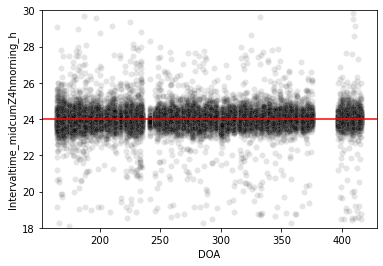

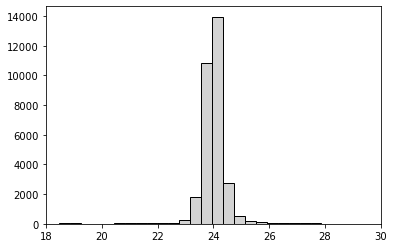

100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [47:29<00:00, 2849.20s/it]


In [138]:
#morning
#for Zid in tqdm.tqdm(['2','3','4','5']):
for Zid in tqdm.tqdm(['4']):
    df_['mid_cum_Z'+Zid+'_sec_Morning'] = df_['list_ZALL'].map(lambda x: mid_cum_Z_sec(eval(x)[0:((8-2)*60*60)],zid=Zid))
    name_ = 'mid_cum_Z'+Zid+'_h_Morning'
    df_[name_] = df_['mid_cum_Z'+Zid+'_sec_Morning'].map(lambda x: x/60/60+2)
    df_['previous_'+name_] = df_.apply(lambda x: df_[(df_['HenID']==x['HenID'])&\
                                                                              (df_['level']==x['level']-dt.timedelta(days=1))][name_].values, axis=1)
    df_['previous_'+name_] = df_['previous_'+name_].map(lambda x: x[0] if len(x)==1 else np.nan)
    df_['Intervaltime_midcumZ'+Zid+'hmorning_h'] = df_.apply(lambda x: 24+(x[name_]-x['previous_'+name_]) if not math.isnan(x['previous_'+name_]) else np.nan, axis=1)
    sns.scatterplot(y='Intervaltime_midcumZ'+Zid+'hmorning_h',x='DOA',data=df_,alpha=0.1,color='black');
    plt.axhline(24,color='red');
    plt.ylim(18,30)
    plt.savefig(os.path.join(path_extracted_data,'Intervaltime_overtime_midcumZ'+Zid+'hmorning_h'+'.png'),dpi=300,format='png',bbox_inches='tight')
    plt.show();
    plt.hist(df_['Intervaltime_midcumZ'+Zid+'hmorning_h'], color='lightgrey', edgecolor = "black", bins=30);
    plt.xlim(18,30)
    plt.savefig(os.path.join(path_extracted_data,'Intervaltime_midcumZ'+Zid+'hmorning_h'+'.png'),dpi=300,format='png',bbox_inches='tight')
    plt.show();

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

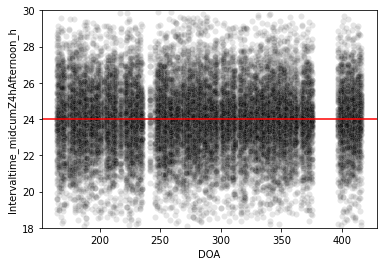

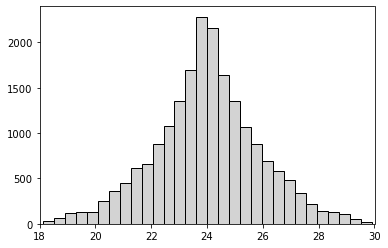

100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [47:22<00:00, 2842.75s/it]


In [139]:
#afternoon (next 6hours)
#for Zid in tqdm.tqdm(['2','3','4','5']):
for Zid in tqdm.tqdm(['4']):
    df_['mid_cum_Z'+Zid+'_sec_Afternoon'] = df_['list_ZALL'].map(lambda x: mid_cum_Z_sec(eval(x)[((8-2)*60*60):((8-2)*60*60)*2],zid=Zid))
    name_ = 'mid_cum_Z'+Zid+'_h_Afternoon'
    df_[name_] = df_['mid_cum_Z'+Zid+'_sec_Afternoon'].map(lambda x: x/60/60+2)
    df_['previous_'+name_] = df_.apply(lambda x: df_[(df_['HenID']==x['HenID'])&\
                                                                              (df_['level']==x['level']-dt.timedelta(days=1))][name_].values, axis=1)
    df_['previous_'+name_] = df_['previous_'+name_].map(lambda x: x[0] if len(x)==1 else np.nan)
    df_['Intervaltime_midcumZ'+Zid+'hAfternoon_h'] = df_.apply(lambda x: 24+(x[name_]-x['previous_'+name_]) if not math.isnan(x['previous_'+name_]) else np.nan, axis=1)
    sns.scatterplot(y='Intervaltime_midcumZ'+Zid+'hAfternoon_h',x='DOA',data=df_,alpha=0.1,color='black');
    plt.axhline(24,color='red');
    plt.ylim(18,30)
    plt.savefig(os.path.join(path_extracted_data,'Intervaltime_overtime_midcumZ'+Zid+'hAfternoon_h'+'.png'),dpi=300,format='png',bbox_inches='tight')
    plt.show();
    plt.hist(df_['Intervaltime_midcumZ'+Zid+'hAfternoon_h'], color='lightgrey', edgecolor = "black", bins=30);
    plt.xlim(18,30)
    plt.savefig(os.path.join(path_extracted_data,'Intervaltime_midcumZ'+Zid+'hAfternoon_h'+'.png'),dpi=300,format='png',bbox_inches='tight')
    plt.show();

#more nan in afternoon as sometimes hens do not use the zone at all, so mid_cum_Z4_sec_Afternoon = nan
df_[(df_['HenID']=='hen_131')&\
   (~df_['Intervaltime_midcumZ'+Zid+'hmorning_h'].isnull())&(df_['Intervaltime_midcumZ'+Zid+'hAfternoon_h'].isnull())][['level','list_ZALL','mid_cum_Z'+Zid+'_sec_Afternoon','previous_mid_cum_Z'+Zid+'_h_Afternoon',
                   'Intervaltime_midcumZ'+Zid+'hAfternoon_h','Intervaltime_midcumZ'+Zid+'hmorning_h']]

In [140]:
#more nan in afternoon as sometimes hens do not use the zone at all, so mid_cum_Z4_sec_Afternoon = nan
li_a = df_[~df_['Intervaltime_midcumZ4hAfternoon_h'].isnull()]['Intervaltime_midcumZ4hAfternoon_h']
li_a.describe()

count    19974.000000
mean        23.993472
std          1.879202
min         18.117222
25%         22.895764
50%         23.993750
75%         25.102500
max         29.902500
Name: Intervaltime_midcumZ4hAfternoon_h, dtype: float64

In [141]:
li_m = df_[~df_['Intervaltime_midcumZ4hmorning_h'].isnull()]['Intervaltime_midcumZ4hmorning_h']
li_m.describe()

count    30898.000000
mean        24.001775
std          0.521525
min         18.073889
25%         23.820000
50%         24.001667
75%         24.183889
max         29.830000
Name: Intervaltime_midcumZ4hmorning_h, dtype: float64

In [144]:
print(np.percentile(li_a,2.5), np.percentile(li_a,97.5))
print(np.percentile(li_m,2.5), np.percentile(li_m,97.5))

20.103402777777777 27.842979166666666
23.263131944444446 24.869881944444444


In [145]:
print(np.percentile(li_a,5), np.percentile(li_a,95))
print(np.percentile(li_m,5), np.percentile(li_m,95))

20.775277777777777 27.171305555555552
23.46023611111111 24.58123611111111


## animal density

In [30]:
#select only time series with the expected amount of observation (15h)
df_['liZ'] = df_['list_ZALL'].map(lambda x: eval(x) if len(eval(x))/60/60==15 else np.nan)

C:\Users\camil\AppData\Local\Temp/ipykernel_34220/1547112728.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['liZ'] = df_['list_ZALL'].map(lambda x: eval(x) if len(eval(x))/60/60==15 else np.nan)


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:34<00:00, 67.00s/it]


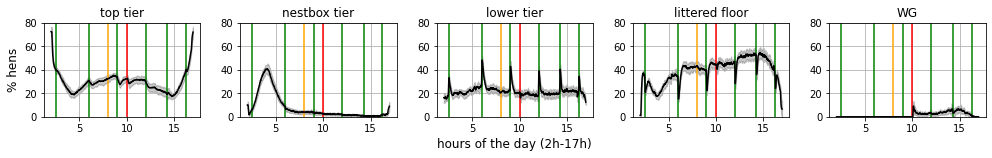

In [82]:
li_z = [5,4,3,2,1]
dico_zid_name = {1:'WG',
                 2:'littered floor',
                 3:'lower tier',
                 4:'nestbox tier',
                 5:'top tier'}
li_hfeed = [2.5,6,9,12,14.25,16.25]


c = len(dico_zid_name.keys()) ; l = 1
img_w = 2.8 ; img_h = 2.3 
fig = plt.figure(figsize=(img_w*c, img_h*l))
i = 1
for Zid in tqdm.tqdm(li_z):
    dico_level_p = {}
    li_other = li_z.copy()
    li_other.remove(Zid)
    for d,df__ in df_.groupby('level'):
        df___ = pd.DataFrame(df__['liZ'].to_list(), columns=range(0,15*60*60))
        #print(df___.shape)
        #display(df___.head(3))
        for z in li_other:
            df___ = df___.replace(z,0)
        df___ = df___.replace(Zid,1)
        #replace Z* by 1, rest by 0 and sum over each seconds over the all hens / nbr hens, so that we have the % of hens in Z*
        #at the second-level
        dico_level_p[d] = list(df___.sum(axis=0)/df___.shape[0]*100)

    df_density = pd.DataFrame.from_dict(dico_level_p)
    #print(df_density.shape)
    #display(df_density.head(3))
    df_density = df_density.transpose().reset_index()
    df_density.rename(columns={'index':'date'}, inplace=True)
    #display(df_density.head(3))
    df_density = pd.melt(df_density, id_vars=['date'], value_vars=range(0,15*60*60), value_name = 'perc_hens_Z'+str(Zid))
    #display(df_density.head(3))
    df_density['incl'] = df_density['variable'].map(lambda x: x%60==0) #just plot one value per minute of the day
    df_density['hour of the day'] = df_density['variable'].map(lambda x: 2+x/60/60)
    
    plt.subplot(l,c,i)
    plt.tight_layout()
    
    for f in li_hfeed:
        plt.axvline(f,color='green')
    plt.ylim(0,80)
    plt.axvline(10,color='red')
    plt.axvline(8,color='orange')
    sns.lineplot(x='hour of the day', y='perc_hens_Z'+str(Zid), data=df_density[df_density['incl']], color='black',
                 estimator='mean',ci='sd'); #ci='sd, 95 (for 95 CI)
    plt.ylim(0,80)
    #plt.xticks([])
    if Zid!=5:
        #plt.yticks([])
        plt.ylabel('')
    else:
        plt.ylabel('% hens',size=12)
    if Zid==3:
        plt.xlabel('hours of the day (2h-17h)',size=12)
    else:
        plt.xlabel('')
    plt.grid(True)
    plt.title(dico_zid_name[Zid])
    i = i+1
plt.savefig(os.path.join(path_extracted_data,'Henpercentage_overtime_sd.png'),dpi=600,format='png',bbox_inches='tight')
plt.show();